[1] 모듈로딩 및 데이터 준비

In [100]:
# 모듈로딩

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
# 파일경로

DATA_PATH = './train.csv'
spaceDF = pd.read_csv(DATA_PATH)

In [102]:
spaceDF.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


- PassengerId- 각 승객에 대한 고유한 ID. 각 ID는 승객이 함께 여행하는 그룹을 나타내는 형식을 취하며, gggg_pp그룹 내의 번호입니다. 그룹에 속한 사람들은 종종 가족이지만 항상 그런 것은 아닙니다.ggggpp
- HomePlanet- 승객이 출발한 행성, 일반적으로 영주권이 있는 행성입니다.
- CryoSleep- 승객이 항해 기간 동안 정지된 애니메이션 상태에 들어가도록 선택했는지 여부를 나타냅니다. 냉동 수면 상태의 승객은 객실에 갇힙니다.
- Cabin- 승객이 머물고 있는 객실 번호. 형식을 취하며 deck/num/side, 여기서는 Port 또는 Starboard 중 하나 를side 사용할 수 있습니다 .PS
- Destination- 승객이 하선할 행성.
- Age- 승객의 나이.
- VIP- 승객이 항해 중 특별 VIP 서비스에 대한 비용을 지불했는지 여부.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck- 승객이 타이타닉호의 다양한 고급 편의시설에 대해 청구한 금액입니다.
- Name- 승객의 성과 이름.
- Transported- 승객이 다른 차원으로 이동했는지 여부. 이것이 타겟이고, 당신이 예측하려는 열입니다.


[2] 데이터 전처리

In [103]:
# 중복값 체크
spaceDF.duplicated().sum()

0

In [104]:
# NAN 체크
spaceDF.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [105]:
# 전부 중복인 값, 한개라도 중복인값 체크
# 대부분 각 컬럼별 결측치, 삭제아닌 최대한 채우기로 결정
spaceDF.isna().all(axis=1).sum(), spaceDF.isna().any(axis=1).sum()

(0, 2087)

In [106]:
# 모든 금액이 결측치인 데이터 체크 없으므로 개인별 총 지불한 금액 평균치를 대입하기로 결정
space_cols =spaceDF.columns[[7,8,9,10,11]].to_list()
spaceDF[space_cols].isna().all(axis=1).sum()

0

In [107]:
# 개인별 지불한 금액 평균치로 지정 대입
for col in space_cols:
    pId = spaceDF.loc[spaceDF[col].isna(),'PassengerId']
    for idx in pId:
        p = spaceDF['PassengerId'] == idx
        spaceDF.loc[p,col] = spaceDF.loc[p,space_cols].mean(axis=1)
        print(spaceDF.loc[p,col])

25    0.0
Name: RoomService, dtype: float64
35    685.0
Name: RoomService, dtype: float64
83    0.0
Name: RoomService, dtype: float64
132    24.25
Name: RoomService, dtype: float64
170    270.0
Name: RoomService, dtype: float64
220    222.0
Name: RoomService, dtype: float64
233    0.0
Name: RoomService, dtype: float64
280    1236.75
Name: RoomService, dtype: float64
319    473.5
Name: RoomService, dtype: float64
368    430.0
Name: RoomService, dtype: float64
400    0.0
Name: RoomService, dtype: float64
401    1918.5
Name: RoomService, dtype: float64
444    73.75
Name: RoomService, dtype: float64
448    83.0
Name: RoomService, dtype: float64
550    58.25
Name: RoomService, dtype: float64
568    196.75
Name: RoomService, dtype: float64
637    1776.0
Name: RoomService, dtype: float64
646    189.0
Name: RoomService, dtype: float64
820    663.25
Name: RoomService, dtype: float64
889    0.0
Name: RoomService, dtype: float64
905    10.0
Name: RoomService, dtype: float64
908    1.333333
Name: 

In [108]:
# 결측치가 데이터의 2% 정도이기에 만약 최빈값이 1000개가 넘어간다면 최빈값으로 치환
def mode_fill(colname):
    mod_d = spaceDF[colname].mode().values[0]
    mod_cnt = spaceDF.loc[spaceDF[colname] == mod_d,colname].count()
    if int(mod_cnt) > 1000:
        print(colname,': 최빈값으로 치환')
        spaceDF[colname].fillna(mod_d,inplace=True)
    else:
        print(colname,': 치환안됨')
    print(f'최빈값 개수:{mod_cnt}, 최빈값: {mod_d}')
    print()
mode_fill('HomePlanet')
mode_fill('CryoSleep')
mode_fill('Cabin')
mode_fill('Destination')

HomePlanet : 최빈값으로 치환
최빈값 개수:4602, 최빈값: Earth

CryoSleep : 최빈값으로 치환
최빈값 개수:5439, 최빈값: False

Cabin : 치환안됨
최빈값 개수:8, 최빈값: G/734/S

Destination : 최빈값으로 치환
최빈값 개수:5915, 최빈값: TRAPPIST-1e



In [109]:
# 최빈값 너무 작음 각데이터 연관성 찾힘힘든 8700개 데이터중 200개이기에 삭제 결정
spaceDF['Cabin'].value_counts()

Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64

In [110]:
# 방에 대한 데이터 확인불가, 삭제
spaceDF.drop(index=spaceDF[spaceDF['Cabin'].isna()].index,inplace=True)

<Axes: >

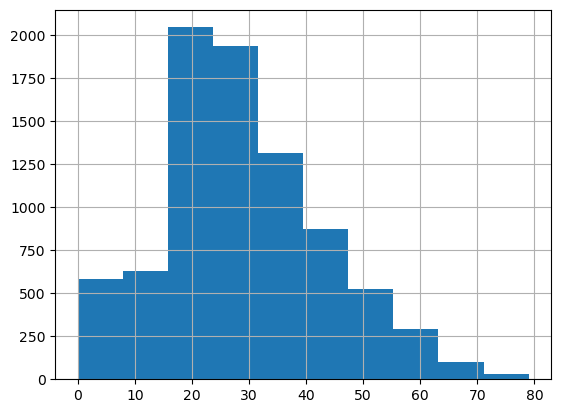

In [111]:
# 연령별 분포도 히스토그램, 딱히 문제없으므로 평균치대입
spaceDF['Age'].hist()

In [112]:
# 나이 평균치 대입
spaceDF.loc[spaceDF['Age'].isna(),'Age'] = spaceDF['Age'].mean()

In [113]:
# VIP 멤버들이 평균적으로 사용한 금액 추출
vipCut = spaceDF.loc[spaceDF['VIP'] == True,space_cols].mean(axis=1).mean()
vipidx = spaceDF.loc[spaceDF['VIP'].isna(),'PassengerId']

In [114]:
# VIP 멤버들이 평균적으로 사용한 금액이상으로 썻다면 VIP로 대입
for idx in vipidx:
    h_m = spaceDF.loc[spaceDF['PassengerId'] == idx,space_cols].mean(axis=1).values[0]
    if h_m >= vipCut:
        spaceDF.loc[spaceDF['PassengerId'] == idx,'VIP'] = True
    else:
        spaceDF.loc[spaceDF['PassengerId'] == idx,'VIP'] = False

In [115]:
spaceDF.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [116]:
spaceDF.shape

(8494, 14)

In [117]:
spaceDF.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [118]:
for i in range(len(spaceDF.columns)): print(f'{spaceDF.columns[i]}.unique(): {spaceDF[spaceDF.columns[i]].unique()}\n')

PassengerId.unique(): ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']

HomePlanet.unique(): ['Europa' 'Earth' 'Mars']

CryoSleep.unique(): [False  True]

Cabin.unique(): ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Destination.unique(): ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']

Age.unique(): [39.         24.         58.         33.         16.         44.
 26.         28.         35.         14.         34.         45.
 32.         48.         27.          0.          1.         49.
 29.         10.          7.         21.         62.         15.
 43.         47.          2.         20.         23.         30.
 17.         55.          4.         19.         56.         28.82041111
 25.         38.         36.         22.         18.         42.
 37.         13.          8.         40.          3.         54.
  9.          6.         31.         64.         67.         61.
 50.         41.         57.         11.         52.         51.
 46.    

In [119]:
spaceDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8494 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8494 non-null   object 
 1   HomePlanet    8494 non-null   object 
 2   CryoSleep     8494 non-null   bool   
 3   Cabin         8494 non-null   object 
 4   Destination   8494 non-null   object 
 5   Age           8494 non-null   float64
 6   VIP           8494 non-null   object 
 7   RoomService   8494 non-null   float64
 8   FoodCourt     8494 non-null   float64
 9   ShoppingMall  8494 non-null   float64
 10  Spa           8494 non-null   float64
 11  VRDeck        8494 non-null   float64
 12  Name          8296 non-null   object 
 13  Transported   8494 non-null   bool   
dtypes: bool(2), float64(6), object(6)
memory usage: 879.3+ KB


In [120]:
spaceDF.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            198
Transported       0
dtype: int64

In [121]:
spaceDF.value_counts()

PassengerId  HomePlanet  CryoSleep  Cabin     Destination    Age   VIP    RoomService  FoodCourt  ShoppingMall  Spa    VRDeck  Name               Transported
0001_01      Europa      False      B/0/P     TRAPPIST-1e    39.0  False  0.0          0.0        0.0           0.0    0.00    Maham Ofracculy    False          1
6135_01      Earth       False      F/1272/P  TRAPPIST-1e    24.0  False  270.0        0.0        534.0         0.0    0.00    Joanie Ellahan     False          1
6162_01      Earth       False      F/1181/S  55 Cancri e    22.0  False  0.0          0.0        1.0           575.0  0.00    Bonyan Hineyley    False          1
6158_01      Earth       True       G/996/S   PSO J318.5-22  14.0  False  0.0          0.0        0.0           0.0    0.00    Dawne Jacobbinson  True           1
6157_01      Mars        False      E/407/S   TRAPPIST-1e    49.0  False  460.0        86.0       92.0          659.0  0.00    Weros Bost         False          1
                           

In [122]:
# 사용하지 않는 컬럼 제거
spaceDF.drop(['Cabin','Name','PassengerId'], axis=1, inplace=True)

spaceDF.shape

(8494, 11)

In [123]:
spaceDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8494 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8494 non-null   object 
 1   CryoSleep     8494 non-null   bool   
 2   Destination   8494 non-null   object 
 3   Age           8494 non-null   float64
 4   VIP           8494 non-null   object 
 5   RoomService   8494 non-null   float64
 6   FoodCourt     8494 non-null   float64
 7   ShoppingMall  8494 non-null   float64
 8   Spa           8494 non-null   float64
 9   VRDeck        8494 non-null   float64
 10  Transported   8494 non-null   bool   
dtypes: bool(2), float64(6), object(3)
memory usage: 680.2+ KB


In [124]:
spaceDF.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000
mean,28.820411,223.865866,453.125383,177.809719,306.150989,303.549937
std,14.338048,645.861718,1601.024340,609.777740,1110.331941,1137.368748
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,57.000000,87.750000,32.000000,71.000000,53.750000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,24133.000000


- Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck -> 숫자형이므로 인코딩 필요X
- HomePlanet, CryoSleep, Destination, VIP, Transported -> OneHot 인코딩

In [125]:
# object 타입 데이터 원-핫 인코딩
ex_featureDF = spaceDF[spaceDF.columns[:-1]]
targetSR = spaceDF[spaceDF.columns[-1]]

floatDF = ex_featureDF[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
objDF = ex_featureDF[['HomePlanet','CryoSleep','Destination','VIP']]

In [126]:
# 원핫 인코더
objDF_ohe = pd.get_dummies(objDF, columns=objDF.columns)
objDF_ohe = objDF_ohe.applymap(lambda x: 1 if x is True else (0 if x is False else x))
objDF_ohe

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,0,1,0,1,0,0,0,1,1,0
1,1,0,0,1,0,0,0,1,1,0
2,0,1,0,1,0,0,0,1,0,1
3,0,1,0,1,0,0,0,1,1,0
4,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0,1,0,1,0,0,0,1
8689,1,0,0,0,1,0,1,0,1,0
8690,1,0,0,1,0,0,0,1,1,0
8691,0,1,0,1,0,1,0,0,1,0


In [127]:
target = spaceDF['Transported']
target=pd.DataFrame(target)

target_ohe = pd.get_dummies(target, columns=target.columns,drop_first=True)
target_ohe
target_ohe = target_ohe.applymap(lambda x: 1 if x is True else (0 if x is False else x))
target_ohe

targetSR_ohe = targetSR.astype(int)
targetSR_ohe

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8494, dtype: int32

In [128]:
featureDF_ohe = pd.concat([floatDF, objDF_ohe], axis=1)
featureDF_ohe

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,1,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0,0,1,0,0,0,1,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,1,0,0,0,1,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,1,0,0,0,1,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,0,1,0,1,0,1,0,0,0,1
8689,18.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,1,0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1,0,0,1,0,0,0,1,1,0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,0,1,0,1,0,1,0,0,1,0


In [129]:
print(f'featureDF : {featureDF_ohe.shape}, {featureDF_ohe.ndim}D')
print(f'targetSR : {targetSR_ohe.shape}, {targetSR_ohe.ndim}D')

featureDF : (8494, 16), 2D
targetSR : (8494,), 1D


[2] DecisionTreeclassifier best 값 선별용 피쳐, 타겟 선정

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
x_train, x_test, y_train, y_test = train_test_split(featureDF_ohe,
                                                    targetSR_ohe,
                                                    random_state=10,
                                                    stratify=targetSR_ohe)

In [132]:
print(f'x_train : {x_train.shape}, {x_train.ndim}D')
print(f'x_test : {x_test.shape}, {x_test.ndim}D')

print(f'y_train : {y_train.shape}, {y_train.ndim}D')
print(f'y_test : {y_test.shape}, {y_test.ndim}D')

x_train : (6370, 16), 2D
x_test : (2124, 16), 2D
y_train : (6370,), 1D
y_test : (2124,), 1D


- DecisionTreeClassifier 학습

In [133]:
from sklearn.tree import DecisionTreeClassifier

In [134]:
# 모델 인스턴스 생성
dt_model = DecisionTreeClassifier(random_state=10)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=10)

In [135]:
# 모델 파라미터 : 학습 fit() 후에 학습용 데이터셋을 기반으로 설정된 값들
print(f'[dt_model.classes_]: {dt_model.classes_}')
print(f'[dt_model.n_classes_]: {dt_model.n_classes_}')
print(f'[dt_model.max_features_]: {dt_model.max_features_}')
print(f'[dt_model.feature_importances_]: {dt_model.feature_importances_}')
print(f'[dt_model.feature_names_in_]: {dt_model.feature_names_in_}')

[dt_model.classes_]: [0 1]
[dt_model.n_classes_]: 2
[dt_model.max_features_]: 16
[dt_model.feature_importances_]: [0.1243713  0.09197128 0.10132537 0.07042399 0.13030628 0.13025736
 0.03824436 0.01563229 0.00900567 0.         0.25486282 0.00808501
 0.00821173 0.01279508 0.00254518 0.00196228]
[dt_model.feature_names_in_]: ['Age' 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck'
 'HomePlanet_Earth' 'HomePlanet_Europa' 'HomePlanet_Mars'
 'CryoSleep_False' 'CryoSleep_True' 'Destination_55 Cancri e'
 'Destination_PSO J318.5-22' 'Destination_TRAPPIST-1e' 'VIP_False'
 'VIP_True']


- 성능 체크

In [136]:
# 학습용 데이터셋에 대한 성능
train_score = dt_model.score(x_train, y_train)

# 테스트용 데이터셋에 대한 성능
test_score = dt_model.score(x_test, y_test)

print(f'train_score : test_score = {train_score} : {test_score}')

train_score : test_score = 0.9335949764521193 : 0.7354048964218456


- 교차 검증 => 과대적합을 회피

In [137]:
from sklearn.model_selection import cross_validate

In [138]:
# 교차검증 준비 ==> 모델 인스턴스, trainDS, cv=5[기본]
dt_model2 = DecisionTreeClassifier(random_state=1)
result=cross_validate(dt_model2, x_train, y_train, 
                      return_train_score=True,
                      return_estimator=True)

In [139]:
# dict => DataFrame
resultDF = pd.DataFrame(result)
resultDF

,fit_time,score_time,estimator,test_score,train_score
0,0.033021,0.0,DecisionTreeClassifier(random_state=1),0.726845,0.935636
1,0.031787,0.0,DecisionTreeClassifier(random_state=1),0.729199,0.933673
2,0.031538,0.0,DecisionTreeClassifier(random_state=1),0.737834,0.936813
3,0.031478,0.0,DecisionTreeClassifier(random_state=1),0.747253,0.934655
4,0.031470,0.0,DecisionTreeClassifier(random_state=1),0.729984,0.937991


In [140]:
from sklearn.model_selection import GridSearchCV

In [141]:
# 하이퍼파라미터 dict 생성
params = {'max_depth':[4,3,2,1],
          'min_samples_leaf':[5,3,2]}

In [142]:
dtcv = GridSearchCV(DecisionTreeClassifier(), param_grid=params, refit=True)
dtcv.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 3, 2, 1],
                         'min_samples_leaf': [5, 3, 2]})

In [143]:
# 모델 파라미터 확인

print(f'[dtcv.best_params_]: {dtcv.best_params_}')
print(f'[dtcv.best_score_]: {dtcv.best_score_}')
print(f'[dtcv.best_estimator_]: {dtcv.best_estimator_}')

[dtcv.best_params_]: {'max_depth': 4, 'min_samples_leaf': 5}
[dtcv.best_score_]: 0.7577708006279436
[dtcv.best_estimator_]: DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)


In [144]:
cv_resultDF = pd.DataFrame(dtcv.cv_results_)
cv_resultDF

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010260,0.002800,0.001181,0.000660,4,5,"{'max_depth': 4, 'min_samples_leaf': 5}",0.769231,0.742543,0.757457,0.744898,0.774725,0.757771,0.012779,1
1,0.006883,0.003475,0.001228,0.000780,4,3,"{'max_depth': 4, 'min_samples_leaf': 3}",0.769231,0.742543,0.757457,0.744898,0.774725,0.757771,0.012779,1
2,0.009352,0.007636,0.000000,0.000000,4,2,"{'max_depth': 4, 'min_samples_leaf': 2}",0.769231,0.742543,0.757457,0.744898,0.773940,0.757614,0.012573,3
3,0.009374,0.007654,0.000000,0.000000,3,5,"{'max_depth': 3, 'min_samples_leaf': 5}",0.715856,0.683673,0.750392,0.725275,0.724490,0.719937,0.021487,7
4,0.003125,0.006249,0.004798,0.006573,3,3,"{'max_depth': 3, 'min_samples_leaf': 3}",0.715856,0.683673,0.750392,0.725275,0.724490,0.719937,0.021487,7
5,0.009266,0.007569,0.000000,0.000000,3,2,"{'max_depth': 3, 'min_samples_leaf': 2}",0.715856,0.683673,0.750392,0.725275,0.724490,0.719937,0.021487,7
6,0.004560,0.006172,0.003368,0.006145,2,5,"{'max_depth': 2, 'min_samples_leaf': 5}",0.715856,0.725275,0.733909,0.718995,0.722920,0.723391,0.006173,4
7,0.005204,0.000523,0.001655,0.000651,2,3,"{'max_depth': 2, 'min_samples_leaf': 3}",0.715856,0.725275,0.733909,0.718995,0.722920,0.723391,0.006173,4
8,0.005439,0.000472,0.001373,0.000458,2,2,"{'max_depth': 2, 'min_samples_leaf': 2}",0.715856,0.725275,0.733909,0.718995,0.722920,0.723391,0.006173,4
9,0.003347,0.000434,0.001779,0.000391,1,5,"{'max_depth': 1, 'min_samples_leaf': 5}",0.715856,0.725275,0.718995,0.700942,0.722920,0.716797,0.008561,10


In [145]:
cv_resultDF.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

- 주요 피쳐 시각화

In [146]:
# 가장 좋은 모델
best_model = dtcv.best_estimator_
print(f'[best_model.max_depth]: {best_model.max_depth}')
print(f'[best_model.min_samples_leaf]: {best_model.min_samples_leaf}')

[best_model.max_depth]: 4
[best_model.min_samples_leaf]: 5


In [147]:
# 피쳐 중요도 및 개수
best_model.feature_importances_, best_model.n_features_in_

(array([0.00654926, 0.08119435, 0.02988282, 0.01055733, 0.10155282,
        0.11746172, 0.07327577, 0.        , 0.00327096, 0.        ,
        0.57318888, 0.00306609, 0.        , 0.        , 0.        ,
        0.        ]),
 16)

In [148]:
best_model.feature_names_in_

array(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'CryoSleep_False', 'CryoSleep_True', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
       'VIP_False', 'VIP_True'], dtype=object)

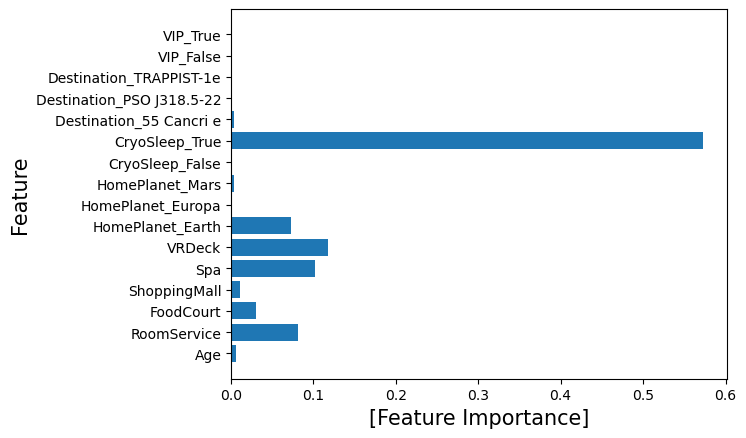

In [149]:
import matplotlib.pyplot as plt

plt.barh(range(best_model.n_features_in_), best_model.feature_importances_, align='center')
plt.yticks(np.arange(best_model.n_features_in_), best_model.feature_names_in_)
plt.xlabel('[Feature Importance]', size=15)
plt.ylabel('Feature', size=15)
plt.show()

In [150]:
## [1] DT모델을 dot포맷의 파일로 저장 ==> export_graphviz()

from sklearn.tree import export_graphviz

export_graphviz(best_model, out_file='space_tree.dot',
                class_names=best_model.feature_names_in_,
                feature_names=best_model.feature_names_in_,
                impurity=True,
                filled=True,
                rounded=True,
                precision=2,
                special_characters=True)

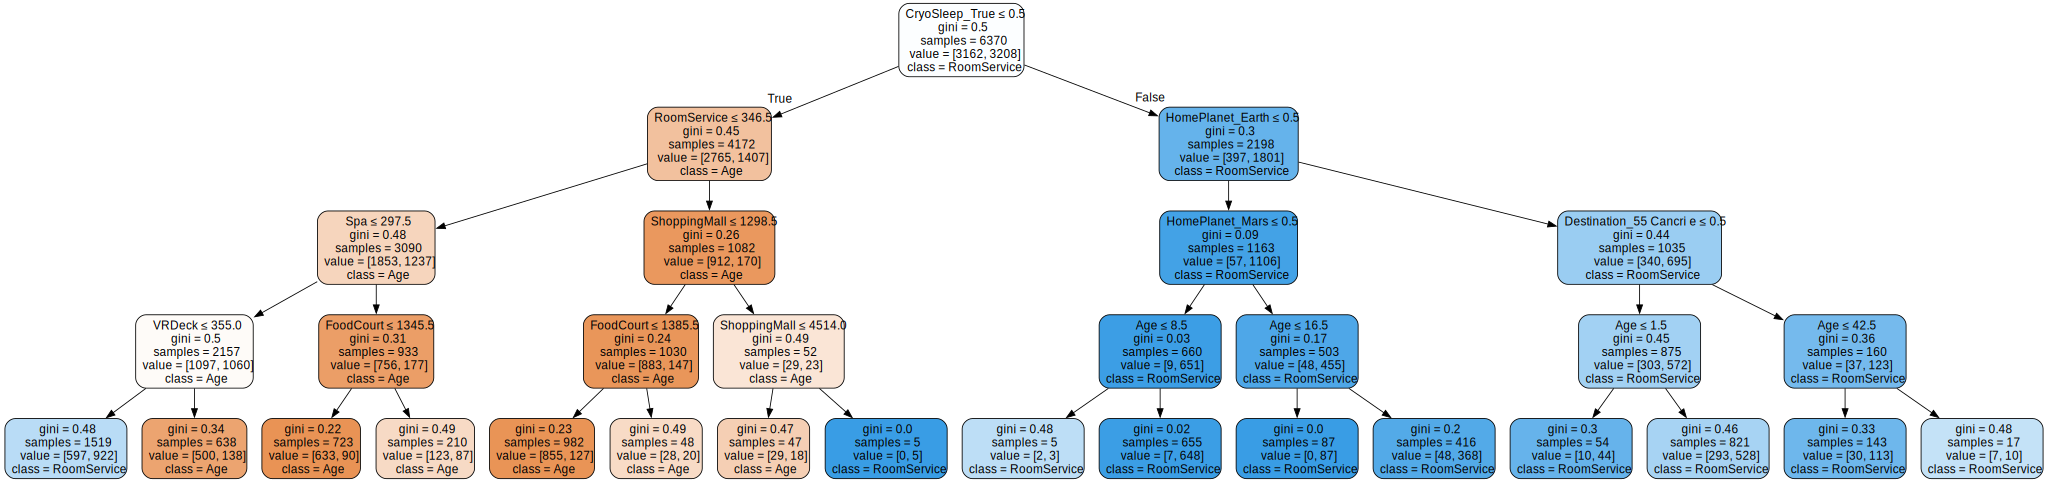

In [151]:
## [2] dot파일 출력
import graphviz
# 파일에서 데이터 읽어오기
with open('space_tree.dot') as f:
    dot_data = f.read()

# 화면에 출력하기
graphviz.Source(dot_data)

In [152]:
# 예측
y_pred = best_model.predict(x_test)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [153]:
from sklearn.metrics import classification_report

In [154]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.65      0.73      1054
           1       0.71      0.85      0.78      1070

    accuracy                           0.75      2124
   macro avg       0.76      0.75      0.75      2124
weighted avg       0.76      0.75      0.75      2124



- 랜덤 포레스트 적용

In [155]:
from sklearn.ensemble import RandomForestClassifier

In [156]:
# 인스턴스 생성 => 데이터셋 생성
#                 random_state 매개변수 설정으로 고정된 데이터셋 생성
#                 oob_score 매개변수 : 샘플 데이터셋 추출 후 남은 데이터셋 검증용으로 사용
lf_model = RandomForestClassifier(random_state=7, 
                                  oob_score=True)

# 학습
lf_model.fit(x_train, y_train)

RandomForestClassifier(oob_score=True, random_state=7)

In [157]:
# 모델 파라미터 확인

print(f'lf_model.classes_            : {lf_model.classes_}')
print(f'lf_model.n_classes_          : {lf_model.n_classes_}')

print(f'lf_model.feature_names_in_   : {lf_model.feature_names_in_}')
print(f'lf_model.n_features_in_      : {lf_model.n_features_in_}')
print(f'lf_model.feature_importances_: {lf_model.feature_importances_}')

lf_model.classes_            : [0 1]
lf_model.n_classes_          : 2
lf_model.feature_names_in_   : ['Age' 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck'
 'HomePlanet_Earth' 'HomePlanet_Europa' 'HomePlanet_Mars'
 'CryoSleep_False' 'CryoSleep_True' 'Destination_55 Cancri e'
 'Destination_PSO J318.5-22' 'Destination_TRAPPIST-1e' 'VIP_False'
 'VIP_True']
lf_model.n_features_in_      : 16
lf_model.feature_importances_: [0.17384801 0.12173512 0.10875222 0.09354236 0.12460123 0.11698405
 0.02825973 0.02072206 0.01064821 0.08823991 0.08514119 0.00900293
 0.00579318 0.00880902 0.00197028 0.0019505 ]


In [159]:
# 모델 파라미터 확인2

print(f'lf_model.estimator_            : {lf_model.estimator_}')
for est in lf_model.estimators_: print(est)

lf_model.estimator_            : DecisionTreeClassifier()
DecisionTreeClassifier(max_features='sqrt', random_state=327741615)
DecisionTreeClassifier(max_features='sqrt', random_state=976413892)
DecisionTreeClassifier(max_features='sqrt', random_state=1202242073)
DecisionTreeClassifier(max_features='sqrt', random_state=1369975286)
DecisionTreeClassifier(max_features='sqrt', random_state=1882953283)
DecisionTreeClassifier(max_features='sqrt', random_state=2053951699)
DecisionTreeClassifier(max_features='sqrt', random_state=959775639)
DecisionTreeClassifier(max_features='sqrt', random_state=1956722279)
DecisionTreeClassifier(max_features='sqrt', random_state=2052949340)
DecisionTreeClassifier(max_features='sqrt', random_state=1322904761)
DecisionTreeClassifier(max_features='sqrt', random_state=165338510)
DecisionTreeClassifier(max_features='sqrt', random_state=1133316631)
DecisionTreeClassifier(max_features='sqrt', random_state=4812360)
DecisionTreeClassifier(max_features='sqrt', random_s

In [122]:
print(f'lf_model.oob_score_ : {lf_model.oob_score_}')

lf_model.oob_score_ : 0.7822605965463109


- 성능 평가

In [123]:
train_score = lf_model.score(x_train, y_train)
test_score = lf_model.score(x_test, y_test)

print(f'train_score : test_score = {train_score} : {test_score}')

train_score : test_score = 0.9334379905808478 : 0.78060263653484


- 튜닝

In [124]:
# 모듈 로딩
from sklearn.model_selection import RandomizedSearchCV

In [125]:
# RandomForestClassifier 하이퍼 파라미터 설정
params = {'max_depth':range(2, 16),
          'min_samples_leaf':range(5, 16),
          'criterion': ['gini', 'entropy', 'log_loss']}

In [126]:
rf_model = RandomForestClassifier(random_state=7)

In [127]:
searchCV = RandomizedSearchCV(rf_model,
                              param_distributions=params,
                              n_iter=50,
                              verbose=4)

In [128]:
searchCV.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END criterion=entropy, max_depth=13, min_samples_leaf=10;, score=0.805 total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=13, min_samples_leaf=10;, score=0.795 total time=   0.5s
[CV 3/5] END criterion=entropy, max_depth=13, min_samples_leaf=10;, score=0.800 total time=   0.5s
[CV 4/5] END criterion=entropy, max_depth=13, min_samples_leaf=10;, score=0.791 total time=   0.5s
[CV 5/5] END criterion=entropy, max_depth=13, min_samples_leaf=10;, score=0.802 total time=   0.5s
[CV 1/5] END criterion=gini, max_depth=10, min_samples_leaf=7;, score=0.803 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=10, min_samples_leaf=7;, score=0.788 total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=10, min_samples_leaf=7;, score=0.799 total time=   0.4s
[CV 4/5] END criterion=gini, max_depth=10, min_samples_leaf=7;, score=0.794 total time=   0.4s
[CV 5/5] END criterion=gini, max_depth=10, min_samples_leaf=7;,

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=7), n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(2, 16),
                                        'min_samples_leaf': range(5, 16)},
                   verbose=4)

In [129]:
# 모델 파라미터 확인
searchCV.best_score_
print(f'searchCV.best_score_ : {searchCV.best_score_}')
print(f'searchCV.best_params_ : {searchCV.best_params_}')
print(f'searchCV.best_estimator_ : {searchCV.best_estimator_}')

searchCV.best_score_ : 0.7995290423861853
searchCV.best_params_ : {'min_samples_leaf': 9, 'max_depth': 12, 'criterion': 'gini'}
searchCV.best_estimator_ : RandomForestClassifier(max_depth=12, min_samples_leaf=9, random_state=7)


In [135]:
cv_resultDF = pd.DataFrame(searchCV.cv_results_)
cv_resultDF.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.561967,0.015640,0.023856,0.005228,10,13,entropy,"{'min_samples_leaf': 10, 'max_depth': 13, 'cri...",0.804553,0.795133,0.799843,0.791209,0.802198,0.798587,0.004828,2
1,0.508148,0.012825,0.018242,0.002011,7,10,gini,"{'min_samples_leaf': 7, 'max_depth': 10, 'crit...",0.802983,0.788069,0.799058,0.794349,0.800628,0.797017,0.005291,7
2,0.341865,0.019487,0.019660,0.005824,12,5,log_loss,"{'min_samples_leaf': 12, 'max_depth': 5, 'crit...",0.787284,0.784144,0.769231,0.759812,0.781005,0.776295,0.010258,31
3,0.195773,0.004992,0.015054,0.005460,14,2,log_loss,"{'min_samples_leaf': 14, 'max_depth': 2, 'crit...",0.722135,0.735479,0.722920,0.701727,0.724490,0.721350,0.010933,47
4,0.301334,0.021235,0.013245,0.004758,14,4,entropy,"{'min_samples_leaf': 14, 'max_depth': 4, 'crit...",0.772370,0.766091,0.751177,0.740188,0.762951,0.758556,0.011478,40
5,0.319749,0.027625,0.015106,0.007229,13,4,gini,"{'min_samples_leaf': 13, 'max_depth': 4, 'crit...",0.773940,0.770016,0.751962,0.741758,0.768446,0.761224,0.012295,37
6,0.283650,0.019085,0.014094,0.001246,7,3,log_loss,"{'min_samples_leaf': 7, 'max_depth': 3, 'crite...",0.748038,0.744113,0.736264,0.719780,0.743328,0.738305,0.010010,43
7,0.291467,0.011308,0.016886,0.003713,9,4,gini,"{'min_samples_leaf': 9, 'max_depth': 4, 'crite...",0.776295,0.771586,0.750392,0.741758,0.767661,0.761538,0.013204,36
8,0.290145,0.003375,0.013439,0.006584,5,4,gini,"{'min_samples_leaf': 5, 'max_depth': 4, 'crite...",0.773155,0.772370,0.750392,0.746468,0.770016,0.762480,0.011585,34
9,0.308684,0.032360,0.010909,0.006765,8,4,gini,"{'min_samples_leaf': 8, 'max_depth': 4, 'crite...",0.777080,0.771586,0.749608,0.742543,0.768446,0.761852,0.013363,35


In [134]:
cv_resultDF = cv_resultDF.sort_values(by='rank_test_score')
cv_resultDF.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.512955,0.012312,0.017038,0.000744,9,12,gini,"{'min_samples_leaf': 9, 'max_depth': 12, 'crit...",0.806907,0.794349,0.800628,0.793564,0.802198,0.799529,0.005004,1
0,0.561967,0.015640,0.023856,0.005228,10,13,entropy,"{'min_samples_leaf': 10, 'max_depth': 13, 'cri...",0.804553,0.795133,0.799843,0.791209,0.802198,0.798587,0.004828,2
40,0.547702,0.019308,0.021720,0.008414,10,15,gini,"{'min_samples_leaf': 10, 'max_depth': 15, 'cri...",0.802198,0.791994,0.796703,0.795918,0.802198,0.797802,0.003928,3
26,0.501472,0.010742,0.021524,0.004588,11,15,gini,"{'min_samples_leaf': 11, 'max_depth': 15, 'cri...",0.803768,0.791209,0.799058,0.794349,0.799843,0.797645,0.004396,4
32,0.586115,0.011847,0.020518,0.006556,9,11,log_loss,"{'min_samples_leaf': 9, 'max_depth': 11, 'crit...",0.802198,0.789639,0.804553,0.791994,0.799058,0.797488,0.005768,5
17,0.535049,0.003491,0.018078,0.008272,8,13,gini,"{'min_samples_leaf': 8, 'max_depth': 13, 'crit...",0.807692,0.789639,0.795918,0.789639,0.802983,0.797174,0.007204,6
41,0.499616,0.000638,0.020349,0.006524,11,11,gini,"{'min_samples_leaf': 11, 'max_depth': 11, 'cri...",0.805338,0.791994,0.799843,0.791209,0.796703,0.797017,0.005221,7
1,0.508148,0.012825,0.018242,0.002011,7,10,gini,"{'min_samples_leaf': 7, 'max_depth': 10, 'crit...",0.802983,0.788069,0.799058,0.794349,0.800628,0.797017,0.005291,7
12,0.631494,0.034389,0.024500,0.007794,9,15,log_loss,"{'min_samples_leaf': 9, 'max_depth': 15, 'crit...",0.803768,0.789639,0.795918,0.794349,0.800628,0.796860,0.004924,9
45,0.552882,0.012213,0.020381,0.006483,13,14,entropy,"{'min_samples_leaf': 13, 'max_depth': 14, 'cri...",0.801413,0.787284,0.801413,0.795133,0.798273,0.796703,0.005254,10


In [160]:
# 가장 좋은 모델
rf_best_model = dtcv.best_estimator_

print(f'[rf_best_model.max_depth]: {rf_best_model.max_depth}')
print(f'[rf_best_model.min_samples_leaf]: {rf_best_model.min_samples_leaf}')

[rf_best_model.max_depth]: 4
[rf_best_model.min_samples_leaf]: 5


In [161]:
# 가장 좋은 모델 스코어 확인
rf_train_score = rf_best_model.score(x_train, y_train)
rf_test_score = rf_best_model.score(x_test, y_test)

print(f'train_score : test_score = {rf_train_score} : {rf_test_score}')

train_score : test_score = 0.7686028257456828 : 0.7542372881355932


In [162]:
# 예측2
y_pred2 = rf_best_model.predict(x_test)
y_pred2

array([0, 0, 0, ..., 1, 1, 0])

In [163]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.81      0.65      0.73      1054
           1       0.71      0.85      0.78      1070

    accuracy                           0.75      2124
   macro avg       0.76      0.75      0.75      2124
weighted avg       0.76      0.75      0.75      2124

